In [3]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
!pip install GPyOpt
#!pip install ggplot
import GPyOpt
import sklearn.metrics as metrics
from pandas import Timestamp
#from ggplot import *
from torch.autograd import Variable

In [0]:
def normalize(data, norm_type):
    if norm_type == "minmax":
        for i in range(data.size()[1]):
            data[:,i] = (data[:,i]-data[:,i].min()) / (data[:,i].max()-data[:,i].min())
        return data
    elif norm_type == "zscore":
        for i in range(data.size()[1]):
            data[:,i] = (data[:,i]-data[:,i].mean()) / (data[:,i].std())
        return data
    elif norm_type == None:
        return data
    else:
        raise ValueError("Please choose a correct normalization type")
#Xnumtrain = torch.tensor(np.vstack([(Xnumtrain[:,i]-Xnumtrain[:,i].min()) / (Xnumtrain[:,i].max()-Xnumtrain[:,i].min()) for i in range(Xnumtrain.size()[1]) if "Tue elsker det her"])).view(-1,2)

def dataprep(data, norm_type = "zscore"):
    for category in categoricals:
        data[category] = data[category].astype("category")

    catdata = []
    for i in range(len(categoricals)):
        catdata.append(data[categoricals[i]].cat.codes.values)
    catdata = torch.tensor(catdata, dtype = torch.int64).T
    
    
    numdata = np.stack([data[col].values for col in numericals], 1)
    numdata = torch.tensor(numdata, dtype=torch.float)

    normalize(numdata, norm_type)
    return catdata, numdata

def permutation(data, cat):
    perm_data = data.copy()
    rand_num = np.random.randint(0 , len(data[cat]) , len(data[cat]))
    perm_data[cat][np.arange(len(data[cat]))] = data[cat][rand_num] 
    df = perm_data
    return df

def reset_data():
    return pd.read_csv("https://raw.githubusercontent.com/oskarwiese/fagprojekt/master/compas_propublica/compas-scores-two-years.csv")

# Data Visualization and Pre-processing

In [5]:
url = "https://raw.githubusercontent.com/oskarwiese/fagprojekt/master/compas_propublica/compas-scores-two-years.csv"
data = pd.read_csv(url)

use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")
#print(data.columns)

No GPU available.


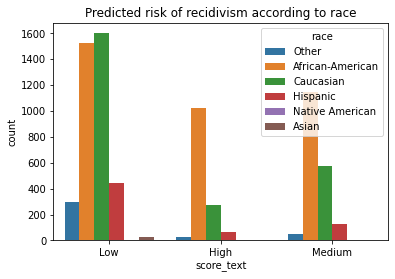

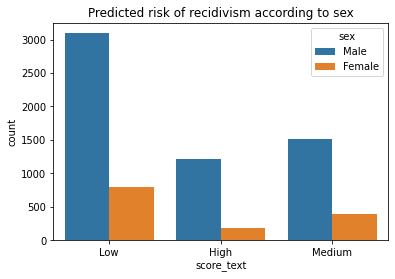

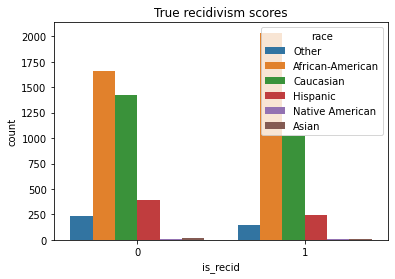

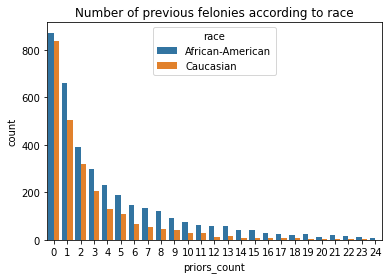

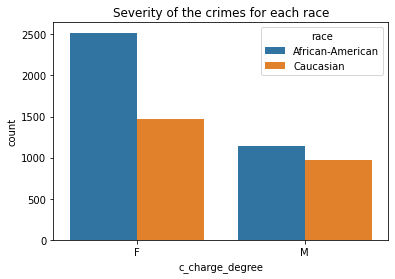

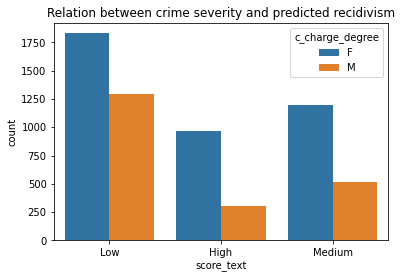

100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


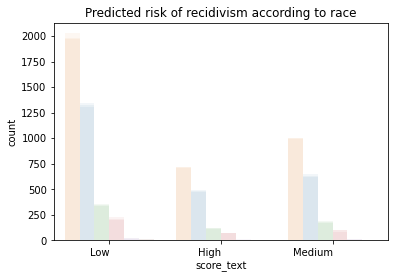

In [6]:
def is_plot():
    
    path = r"C:\Users\ejer\Desktop\Fagprojekt\fagprojekt\report\imgs"
    
    pred_plot_race = sb.countplot(x = "score_text", hue = "race", data = data)
    pred_plot_race.set_title("Predicted risk of recidivism according to race")
    pred_plot_race.figure.savefig(path + "\\predicted_recid_race.png")
    plt.show()
    
    pred_plot_sex = sb.countplot(x = "score_text", hue = "sex", data = data)
    pred_plot_sex.set_title("Predicted risk of recidivism according to sex")
    pred_plot_sex.figure.savefig(path + "\\predicted_recid_sex.png")
    plt.show()
    
    true_plot = sb.countplot(x = "is_recid", hue = "race", data = data)
    true_plot.set_title("True recidivism scores")
    true_plot.figure.savefig(path + "\\true_recid.png")
    plt.show()
    
    df = data[(data["race"] == "African-American") | (data["race"] == "Caucasian")]
    df = df[df["priors_count"] < 25]
    
    priors_plot = sb.countplot(x = "priors_count", hue = "race", data = df)
    priors_plot.set_title("Number of previous felonies according to race")
    priors_plot.figure.savefig(path + "\\proirs.png")
    plt.show()
    
    c_charge_degree = sb.countplot(x = "c_charge_degree", hue = "race", data = df)
    c_charge_degree.set_title("Severity of the crimes for each race")
    c_charge_degree.figure.savefig(path + "\\c_charge_degree.png")
    plt.show()
    
    c_charge_degree = sb.countplot(x = "score_text", hue = "c_charge_degree", data = df)
    c_charge_degree.set_title("Relation between crime severity and predicted recidivism")
    c_charge_degree.figure.savefig(path + "\\charge_degree_score.png")
    plt.show()
    
    
is_plot()

palette = {"Caucasian": "C0", "African-American": "C1", "Hispanic": "C2", "Other": "C3" , "Asian": "C4" ,"Native American": "C5"}
for i in tqdm(range(3)):
    #TODO: der skal indsættes punkter for den rigtige data1fordelling. 
    data = permutation(data, "race")
    path = r"C:\Users\ejer\Desktop\Fagprojekt\fagprojekt\report\imgs"
    pred_plot_race = sb.countplot(x = "score_text" ,hue = "race", data = data, palette = palette ,alpha=.06,  hue_order = [ "African-American","Caucasian", "Hispanic", "Other" , "Asian","Native American"])
    pred_plot_race.set_title("Predicted risk of recidivism according to race")
    pred_plot_race.set_xticklabels(pred_plot_race.get_xticklabels(), horizontalalignment ='right')
    pred_plot_race.get_legend().remove()
    data = reset_data()
plt.show()
    


In [0]:
categoricals = ["c_charge_degree", "race", "age_cat", "sex"] # "r_charge_degree"    "two_year_recid"    "is_recid", "is_violent_recid"
numericals = ["age", "priors_count", "juv_fel_count", "juv_misd_count"] # "days_b_screening_arrest"
outputs = ["score_text"]
data = data[categoricals + numericals + outputs + ["two_year_recid"]]

# Making the output binary
data[outputs] = data[outputs].replace('Low',0)
data[outputs] = data[outputs].replace('Medium',1)
data[outputs] = data[outputs].replace('High',1)
data[outputs] = data[outputs].astype("category")

In [0]:
Xcat, Xnum = dataprep(data, norm_type = "zscore")

# Converting the output to tensor
y = torch.tensor(data[outputs].values).flatten()

# Calculation of embedding sizes for the categorical values in the format (unique categorical values, embedding size (dimension of encoding))
categorical_column_sizes = [len(data[column].cat.categories) for column in categoricals]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]

# Train-test split
totalnumber = len(Xnum)
testnumber = int(totalnumber * 0.2)

Xcattrain = Xcat[:totalnumber - testnumber]
Xcattest = Xcat[totalnumber - testnumber:totalnumber]
Xnumtrain = Xnum[:totalnumber - testnumber]
Xnumtest = Xnum[totalnumber - testnumber:totalnumber]
ytrain = y[:totalnumber - testnumber]
ytest = y[totalnumber - testnumber:totalnumber]


# Make sure that we dont validate on training data to compare if the algorithm is biased


normalize(Xnumtrain, "zscore");
normalize(Xnumtest, "zscore");

# Neural Network

In [0]:
class Model(nn.Module):

    def __init__(self, embedding_size, num_numerical_cols, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        self.batch_norm_num = nn.BatchNorm1d(num_numerical_cols)

        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols + num_numerical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i


        all_layers.append(nn.Linear(layers[-1], output_size))
        all_layers.append(nn.Sigmoid())
        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical, x_numerical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)
        x_numerical = self.batch_norm_num(x_numerical)
        x = torch.cat([x, x_numerical], 1)
        x = self.layers(x)
        return x
        

# Train model on data

In [203]:
# Define and show the model
model = Model(categorical_embedding_sizes, 4, 1, [8,16,640,16], p=0.5)
if use_cuda:
    model.cuda()
print(model)

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(6, 3)
    (2): Embedding(3, 2)
    (3): Embedding(2, 1)
  )
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (batch_norm_num): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=11, out_features=8, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=8, out_features=16, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=16, out_features=640, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=640, out_features=16, bias=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=16, out_features=1, bias=True)
    (13): Sigmoid()
  )
)


In [0]:
# Loss function and optimization
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) 
threshold = 0.5

epoch:   1 loss: 13.94526958
epoch:  26 loss: 14.09846592
epoch:  51 loss: 14.36655903
epoch:  76 loss: 14.03144264
epoch: 101 loss: 14.04101658
epoch: 126 loss: 14.38570881
epoch: 151 loss: 14.43837070
epoch: 176 loss: 14.10325336
epoch: 201 loss: 14.05537891
epoch: 226 loss: 14.35698509
epoch: 251 loss: 14.12718964
epoch: 276 loss: 14.26602459
epoch: 301 loss: 14.01708031
epoch: 326 loss: 14.11761475
epoch: 351 loss: 14.21815014
epoch: 376 loss: 14.30911064
epoch: 401 loss: 14.19900036
epoch: 426 loss: 14.06974125
epoch: 451 loss: 14.31868553
epoch: 476 loss: 13.95005703
epoch: 501 loss: 14.06974125
epoch: 526 loss: 14.38092136
epoch: 551 loss: 14.31389809
epoch: 576 loss: 14.08410358
epoch: 601 loss: 14.22293758
epoch: 626 loss: 14.07931614
epoch: 651 loss: 14.08889103
epoch: 676 loss: 13.96920586
epoch: 701 loss: 14.16548920
epoch: 726 loss: 13.90218258
epoch: 751 loss: 14.11761475
epoch: 776 loss: 14.01229286
epoch: 800 loss: 14.2612371445
[[  0 770]
 [  0 672]]
              prec

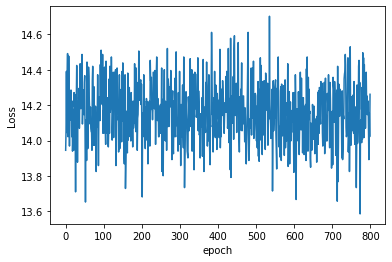

In [207]:
epochs = 800
aggregated_losses = []

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []
model.train()
for i in range(epochs):
    i += 1
    y_pred = model(Xcattrain, Xnumtrain)
    y_pred = (y_pred > threshold).float()
    single_loss = loss_function(y_pred.view(-1).float(), ytrain.view(-1).float())
    single_loss = Variable(single_loss , requires_grad=True )
    aggregated_losses.append(single_loss)
    
    
    if i % 25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
    
    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()
    
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
    


# Plot the loss over epocs
plt.plot(range(epochs), aggregated_losses)
plt.ylabel('Loss')
plt.xlabel('epoch');


# Predict on the test set
model.eval()
#with torch.no_grad():
y_val = model(Xcattest, Xnumtest)
y_val = (y_val > threshold).float()


print(confusion_matrix(ytest.detach().numpy(),y_val.detach().numpy()))
print(classification_report(ytest.numpy(),y_val))
neural_acc = accuracy_score(ytest.detach().numpy(), y_val.detach().numpy())
print(neural_acc)

# Prep black and white

In [0]:
df = data[totalnumber - testnumber:totalnumber]
black_data = df[df["race"]=="African-American"]
white_data = df[df["race"]=="Caucasian"]

Xcat_white, Xnum_white = dataprep(white_data, norm_type = "zscore")
Xcat_black, Xnum_black = dataprep(black_data, norm_type = "zscore")

# A few more plots of blacks and whites

294
450


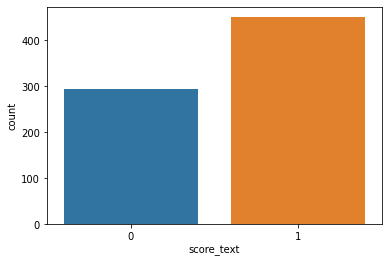

307
168


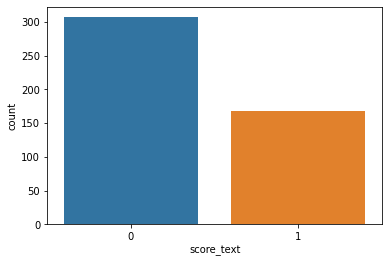

In [183]:
# Plots of the distribution of black and whites in each category of scoretext
sb.countplot(x = "score_text", data = black_data)
print(len(black_data[black_data["score_text"] == 0]))
print(len(black_data[black_data["score_text"] == 1]))
plt.show()
sb.countplot(x = "score_text", data = white_data)
print(len(white_data[white_data["score_text"] == 0]))
print(len(white_data[white_data["score_text"] == 1]))
plt.show()

# Confusion matrix for black/white

In [189]:
model.eval()
y_val_white = model(Xcat_white, Xnum_white)
y_val_white = (y_val_white > threshold).float()
y_val_black = model(Xcat_black, Xnum_black)
y_val_black = (y_val_black > threshold).float()

# Ground truth of recidivism from dataset
y_white = torch.tensor(white_data["two_year_recid"].values).flatten()
y_black = torch.tensor(black_data["two_year_recid"].values).flatten()

print("Confussion matrix for the white:")
conf_white = confusion_matrix( y_white, y_val_white)
print(conf_white)
print(conf_white / conf_white.astype(np.float).sum(axis=1))
print()
print("Confussion matrix for the black:")
conf_black = confusion_matrix( y_black, y_val_black)
print(conf_black)
print(conf_black / conf_black.astype(np.float).sum(axis=1))

Confussion matrix for the white:
[[144 153]
 [ 83  95]]
[[0.48484848 0.85955056]
 [0.27946128 0.53370787]]

Confussion matrix for the black:
[[ 83 266]
 [ 91 304]]
[[0.23782235 0.67341772]
 [0.26074499 0.76962025]]


# ROC 

NameError: ignored

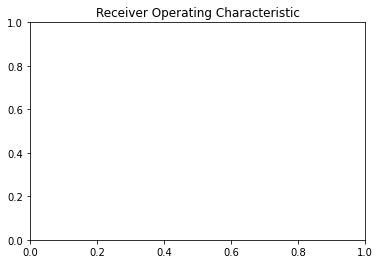

In [64]:
print()
fpr, tpr, threshold = metrics.roc_curve(ytest, y_val)
fpr, tpr, threshold = metrics.roc_curve(y_white, y_val_white)

#print(fpr,tpr,threshold)
#roc_auc = metrics.auc(fpr, tpr)
#df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
#print(ggplot(df, aes(x = 'fpr', y = 'tpr')) + geom_line() + geom_abline(linetype = 'dashed') + ggtitle("ROC Curve w/ AUC = %s" % str(roc_auc)))


# 
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


# Random Forest

In [0]:
# Define the model and fit it to the data
def RandomForest(datatrain, datatest, ytrain, ytest, n_estimators = 53, max_depth = 14, max_features = "log2", criterion = "entropy", show_acc = True):
    forestModel = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, max_features = max_features, criterion = criterion)
    forestModel.fit(datatrain, ytrain)

    # Predict on the test set
    forestPreds = forestModel.predict(datatest)

    forestProbs = forestModel.predict_proba(datatest)[:, 1]

    if show_acc:
        print("Predicted no recidivism: ", len(forestPreds[forestPreds == 0]))
        print("Predicted recidivism: ", len(forestPreds[forestPreds == 1]))

        print("Accuracy of the random forest model: ", len(forestPreds[torch.tensor(forestPreds, dtype = torch.int64) == ytest]) / len(forestPreds))

RandomForest(Xcattrain, Xcattest, ytrain, ytest, n_estimators = 53, max_depth = 14, max_features = "log2", criterion = "entropy", show_acc = True)

Predicted no recidivism:  696
Predicted recidivism:  746
Accuracy of the random forest model:  0.6615811373092927


# Baysian Optimization

In [0]:
## define the domain of the considered parameters
n_estimators = tuple(np.arange(1,301,1, dtype= np.int))
# print(n_estimators)
max_depth = tuple(np.arange(1,110,1, dtype= np.int))
# max_features = ('log2', 'sqrt', None)
max_features = (0, 1)
# criterion = ('gini', 'entropy')
criterion = (0, 1)


# define the dictionary for GPyOpt
domain = [{'n_estimators': 'var_1',  'type': 'discrete',     'domain': n_estimators},
          {'max_depth': 'var_2',     'type': 'discrete',     'domain': max_depth},
          {'max_features': 'var_3',  'type': 'categorical',  'domain': max_features},
          {'criterion': 'var_4',     'type': 'categorical',  'domain': criterion}]


## we have to define the function we want to maximize --> validation accuracy, 
## note it should take a 2D ndarray but it is ok that it assumes only one point
## in this setting
def objective_function(x): 
    print(x)
    # we have to handle the categorical variables that is convert 0/1 to labels
    # log2/sqrt and gini/entropy
    
    param = x[0]
    
    if param[2] == 0:
        var_3 = "log2"
    else:
        var_3 = "sqrt"
    
    if param[3] == 0:
        var_4 = "gini"
    else:
        var_4 = "entropy"
        
        
#fit the model
    model = RandomForestClassifier(n_estimators = int(param[0]), criterion = var_4, max_depth = int(param[1]), max_features = var_3)
    model.fit(Xcattrain, ytrain)
    forestPreds = model.predict(Xcattest)
    accuracy = len(forestPreds[torch.tensor(forestPreds, dtype = torch.int64) == ytest]) / len(forestPreds)
    return accuracy


opt = GPyOpt.methods.BayesianOptimization(f = objective_function,   # function to optimize
                                              domain = domain,         # box-constrains of the problem
                                              acquisition_type = "EI",      # Select acquisition function MPI, EI, LCB
                                             )
opt.acquisition.exploration_weight=.1

opt.run_optimization(max_iter = 100) 


x_best = opt.X[np.argmin(opt.Y)]
print("The best parameters obtained: n_estimators=" + str(x_best[0]) + ", max_depth=" + str(x_best[1]) + ", max_features=" + str(
    x_best[2])  + ", criterion=" + str(
    x_best[3]))

[[290.   2.   0.   1.]]
[[170.  73.   0.   1.]]
[[160.  40.   1.   1.]]
[[27. 62.  0.  0.]]
[[55. 59.  1.  0.]]
[[290.   2.   0.   1.]]
[[289.   2.   0.   1.]]
[[300.  54.   1.   0.]]
[[249.   1.   0.   0.]]
[[265.   1.   1.   0.]]
[[290.   1.   0.   0.]]
[[259.   1.   0.   1.]]
[[232.   1.   1.   1.]]
[[1. 1. 1. 1.]]
[[32.  1.  1.  1.]]
[[17.  1.  1.  0.]]
[[65.  1.  0.  0.]]
[[51.  1.  1.  0.]]
[[289.   1.   1.   1.]]
[[275.   1.   0.   1.]]
[[215.   1.   0.   0.]]
[[225.   1.   0.   0.]]
[[92.  1.  1.  0.]]
[[115.   1.   0.   0.]]
[[103.   1.   0.   0.]]
[[177.   1.   1.   0.]]
[[193.   1.   1.   0.]]
[[146.   1.   1.   0.]]
[[109.   1.   1.   1.]]
[[11.  1.  0.  1.]]
[[1. 1. 0. 0.]]
[[159.   1.   0.   1.]]
[[133.   1.   0.   1.]]
[[82.  1.  0.  1.]]
[[219.   1.   1.   0.]]
[[68.  1.  1.  1.]]
[[184.   1.   0.   1.]]
[[150.   1.   0.   0.]]
[[204.   1.   1.   1.]]
[[290.   1.   0.   1.]]
[[76.  1.  1.  0.]]
[[263.   8.   0.   1.]]
[[108. 109.   0.   0.]]
[[229. 109.   0.   0.]]
[[  

# Baseline

In [0]:

def baseline(data):
    if len(data[data["score_text"] == 0]) > len(data[data["score_text"] == 1]):
        y_pred = [0] * len(data["score_text"])
        y_pred = torch.tensor(y_pred)
    else:
        y_pred = [1] * len(data["score_text"])
        y_pred = torch.tensor(y_pred)
    return y_pred

trues = torch.tensor(data["score_text"])
y_pred = baseline(data)
conf_baseline = confusion_matrix(y_pred,trues)
print(conf_baseline)
print(conf_baseline / conf_baseline.astype(np.float).sum())
baseline_acc = accuracy_score(y_pred, trues)
print(baseline_acc)
print("Difference between baseline and neural network:", neural_acc - baseline_acc)

[[3897 3317]
 [   0    0]]
[[0.54019961 0.45980039]
 [0.         0.        ]]
0.5401996118658164
Difference between baseline and neural network: 0.17963395262794224
